# Tutorial4: Synthesizing EHT observations
---
This tutorial demonstrates how to synthesize EHT VLBI observations from videos.  
This notebook requires [`eht-imaging`](https://achael.github.io/eht-imaging/).

In [1]:
%matplotlib notebook
import pynoisy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import ehtim as eh

Welcome to eht-imaging! v 1.1.1 



In [2]:
"""
Generate an empty ehtim Observation object.
"""
array = eh.array.load_txt('../eht_arrays/EHT2017.txt')
obs = pynoisy.observation.empty_eht_obs(array, nt=64, tint=60.0)

In [3]:
"""
Generate a stochastic video by modulating an envelope with a Gaussian Random Field. 
Set the field of view (fov) of the video to 160.0 [uas].
"""
diffusion = pynoisy.diffusion.general_xy(nx=64, ny=64)
advection = pynoisy.advection.general_xy(nx=64, ny=64)
solver = pynoisy.forward.HGRFSolver(advection, diffusion, nt=64)
grf = solver.run()

# Use the GRF to modulate an envelope and generate a video with pixels as flux densities 
fov = (160.0, 'uas')
envelope = pynoisy.envelope.ring(nx=64, ny=64, total_flux=0.1).utils_image.set_fov(fov)
grf = grf.utils_image.set_fov(fov)

alpha = 2.0
movie = pynoisy.forward.modulate(envelope, grf, alpha)
movie = movie.utils_movie.set_time(tstart=obs.tstart, tstop=obs.tstop)
fourier = movie.utils_observe.block_fourier()

<IPython.core.display.Javascript object>


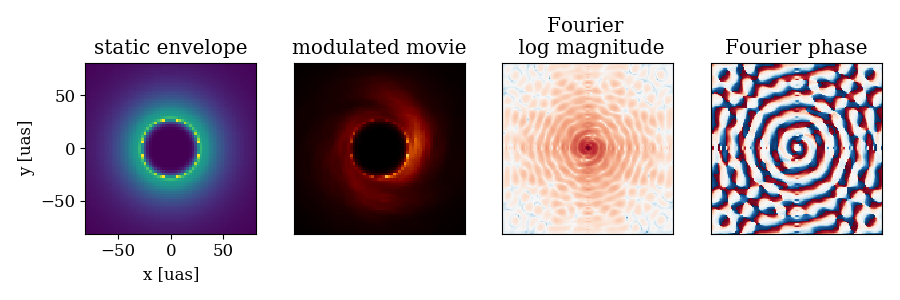

In [4]:
"""
Visualize the static envelope, modulated movie and its Fourier transform (phase and magnitude)
"""
fig, ax = plt.subplots(1, 4, figsize=(9,3))
envelope.plot(ax=ax[0], add_colorbar=False)
ax[0].set_title('static envelope')
ax[0].set_aspect('equal')
movie_list = [movie, fourier.utils_fourier.logmagnitude, fourier.utils_fourier.phase]
titles = ['modulated movie', 'Fourier \n log magnitude', 'Fourier phase']
cmaps = ['afmhot', 'RdBu_r', 'RdBu_r']
plt.tight_layout()
pynoisy.visualization.animate_synced(movie_list, ax[1:], add_colorbars=False, titles=titles, cmaps=cmaps)


Merging 64 frames from MJD 57850 4.05 hr to MJD 57850 15.29 hr
Producing clean visibilities from movie with fast FT . . . 


<IPython.core.display.Javascript object>


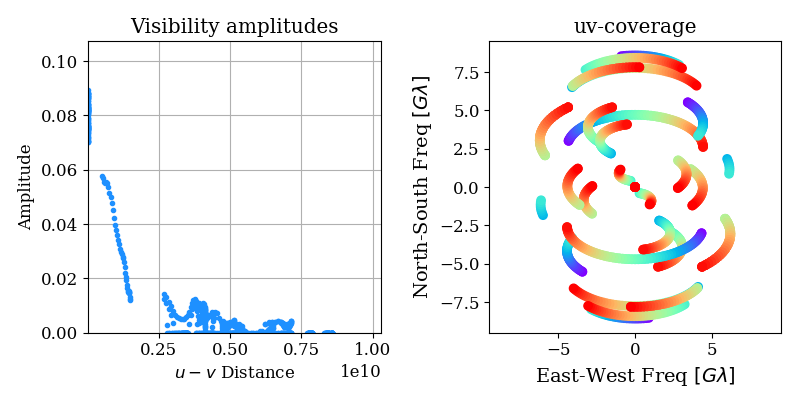

In [5]:
"""
Generate ehtim Movie object and Observation data.
Plot the visibility amplitudes and uv-coverage as a function of time.
"""
movie_ehtim = movie.utils_observe.to_ehtim(source='SYNTHETIC')
obs = movie_ehtim.observe_same_nonoise(obs, ttype='fast')

fig, axes = plt.subplots(1,2, figsize=(8,4))
obs.plotall('uvdist','amp', axis=axes[0], ebar=False);
pynoisy.observation.plot_uv_coverage(obs, ax=axes[1])
axes[0].set_title('Visibility amplitudes')
axes[1].set_title('uv-coverage')
plt.tight_layout()

In [6]:
"""
Observations can be directly computed from the DataArray bypassing ehtim. This is substantially faster when
seeking to compute observations for a block of movies (e.g. many modes).
It is internally implemented using array operations (numpy fft) instead of 
looping over all movies and time frames.
"""
obs_block = movie.utils_observe.block_observe_same_nonoise(obs)

<IPython.core.display.Javascript object>


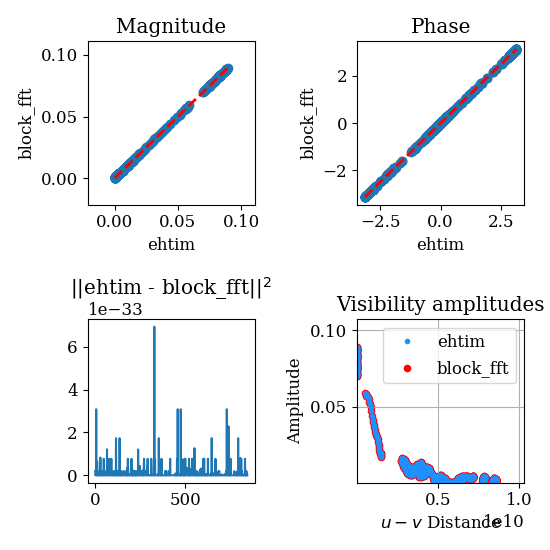

In [7]:
"""
Compare 'block_fft' to the 'ehtim' observations
"""
fig, axes = plt.subplots(2,2, figsize=(5.5, 5.5))
axes[0,0].set_title('Magnitude')
axes[0,0].set_xlabel('ehtim')
axes[0,0].set_ylabel('block_fft')
axes[0,0].scatter(np.abs(obs.data['vis']), np.abs(obs_block))
value_range = [np.abs(obs.data['vis']).min(), np.abs(obs.data['vis']).max()]
axes[0,0].plot(value_range, value_range, color='red', linestyle='--', linewidth=2)

axes[0,1].set_title('Phase')
axes[0,1].set_xlabel('ehtim')
axes[0,1].set_ylabel('block_fft')
value_range = [np.angle(obs.data['vis']).min(), np.angle(obs.data['vis']).max()]
axes[0,1].scatter(np.angle(obs.data['vis']), np.angle(obs_block))
axes[0,1].plot(value_range, value_range, color='red', linestyle='--', linewidth=2)

axes[1,0].set_title(r'$||$ehtim - block_fft$||^2$', y=1.1)
axes[1,0].plot(np.abs(obs.data['vis'] - obs_block)**2)

obs.plotall('uvdist','amp', axis=axes[1,1], ebar=False, debias=False);
obs_block.utils_visualization.visamp(ax=axes[1,1], color='r')
axes[1,1].set_title('Visibility amplitudes')
axes[1,1].legend(labels=['ehtim', 'block_fft'])
plt.tight_layout()